## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,PolynomialFeatures,OrdinalEncoder,OneHotEncoder,power_transform
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

# Header cleaning. More precautionary than anything else
df.columns = [x.strip().lower().replace(' ','').replace('-','') for x in df.columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


## Remove outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x2c775b377f0>,
 'caps': [<matplotlib.lines.Line2D at 0x2c775b37eb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2c775b37490>],
 'medians': [<matplotlib.lines.Line2D at 0x2c775b4e5b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2c775b4e910>],
 'means': []}

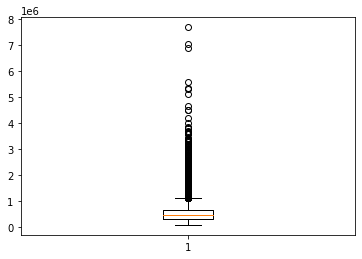

In [4]:
plt.boxplot(df.price)

In [5]:
df.view.isna().sum()

63

In [6]:
# Zach's code
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [7]:
# Removing outliers
df = df[df['bedrooms'] <=15] #2 records remove. 33 BR home
df = df[df['grade'] != '3 Poor'] #only 1 instance of this exists


## Data Cleaning

In [8]:
df.bedrooms

0        3
1        3
2        2
3        4
4        3
        ..
21592    3
21593    4
21594    2
21595    3
21596    2
Name: bedrooms, Length: 20437, dtype: int64

In [9]:
#Making a categorical bedroom columns
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins = [0,1,2,3,4,5,6,99], labels=['1BR','2BR','3BR','4BR','5BR','6BR','7+BR'])

In [10]:
df['bedrooms_bin']

0        3BR
1        3BR
2        2BR
3        4BR
4        3BR
        ... 
21592    3BR
21593    4BR
21594    2BR
21595    3BR
21596    2BR
Name: bedrooms_bin, Length: 20437, dtype: category
Categories (7, object): ['1BR' < '2BR' < '3BR' < '4BR' < '5BR' < '6BR' < '7+BR']

In [11]:
df.bedrooms_bin.value_counts()

3BR     9597
4BR     6304
2BR     2736
5BR     1335
6BR      225
1BR      194
7+BR      46
Name: bedrooms_bin, dtype: int64

(array([ 194., 2736., 9597., 6304., 1335.,  225.,   46.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

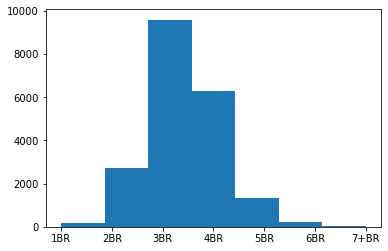

In [12]:
plt.hist(df.bedrooms_bin.sort_values(),bins = 7)

sqft_basement is an object?

In [13]:
df.sqft_basement.sort_values()

0        0.0
12682    0.0
12685    0.0
12686    0.0
12687    0.0
        ... 
1205       ?
9715       ?
12933      ?
19777      ?
4171       ?
Name: sqft_basement, Length: 20437, dtype: object

sqft_basement is a list of strings that include some unknowns marked as '?'

In [14]:
len(df[df.sqft_basement=='?']) /len(df)

0.02113813181973871

In [15]:
df_subset_basement = df[df.sqft_basement !='?'] #subset of  records where sqft_basement is not '?'
df_subset_basement.sqft_basement = df_subset_basement.sqft_basement.astype(float,)

In [16]:
#check to see how much of the current sqft_basement (excluding '?') can be explained by (sqft_living-sqft_above)

(df_subset_basement.sqft_living - df_subset_basement.sqft_above == df_subset_basement.sqft_basement).sum()/df_subset_basement.shape[0]

1.0

So, 98% of the sqft_basement data has a value in it which can be explained using this math. The remaining missing data is filled with '?'. Fill using this math

In [17]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [18]:
# # Change view rating to a numeric value. Probably don't need it
# df['view'] = df['view'].map({'EXCELLENT':5,
#                              'GOOD':4,
#                              'AVERAGE':3,
#                              'FAIR':2,
#                              'NONE':1})

# # Change condition rating to a numeric value. Probably don't need it
# df['condition'] = df['condition'].map({'Very Good':5,
#                                        'Good':4,
#                                        'Average':3,
#                                        'Fair':2,
#                                        'Poor':1})

# # Changing grade to just the numeric value of the grade
# df['grade'] = df['grade'].str.split(' ').str[0].astype(int)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20437 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   id             20437 non-null  int64   
 1   date           20437 non-null  object  
 2   price          20437 non-null  float64 
 3   bedrooms       20437 non-null  int64   
 4   bathrooms      20437 non-null  float64 
 5   sqft_living    20437 non-null  int64   
 6   sqft_lot       20437 non-null  int64   
 7   floors         20437 non-null  float64 
 8   waterfront     18168 non-null  object  
 9   view           20379 non-null  object  
 10  condition      20437 non-null  object  
 11  grade          20437 non-null  object  
 12  sqft_above     20437 non-null  int64   
 13  sqft_basement  20437 non-null  int64   
 14  yr_built       20437 non-null  int64   
 15  yr_renovated   16810 non-null  float64 
 16  zipcode        20437 non-null  int64   
 17  lat            20437 non-null  

In [20]:
#The number of records where view is nan is 0.29% of the dataset. Hence dropped
print(df.view.isna().sum() /df.shape[0])
df.dropna(subset=['view'],inplace=True)

0.002837989920242697


## Analyzing Corelations

In [21]:
df.corr().price.sort_values()

zipcode         -0.018555
id               0.010250
yr_built         0.061387
long             0.072725
sqft_lot15       0.082488
yr_renovated     0.089741
sqft_lot         0.093572
sqft_basement    0.233010
floors           0.273611
bedrooms         0.300831
lat              0.431021
bathrooms        0.455204
sqft_above       0.530569
sqft_living15    0.561947
sqft_living      0.621509
price            1.000000
Name: price, dtype: float64

dropping yr_renovated . not enough records

dropping id, yr_built, floors, date, sqft_lot, sqft_lot15. Not enough correlation. Making predictions based on other columns

stakeholder: potential investor, homebuyer

keeping zipcode, lat, long for the purpose of potential visualizations

In [22]:
df = df.drop(columns = ['id','yr_renovated','floors','date'],axis =1)

In [23]:
df.grade.value_counts()

7 Average        8935
8 Good           5931
9 Better         2308
6 Low Average    2030
10 Very Good      764
5 Fair            242
11 Excellent      137
4 Low              27
12 Luxury           5
Name: grade, dtype: int64

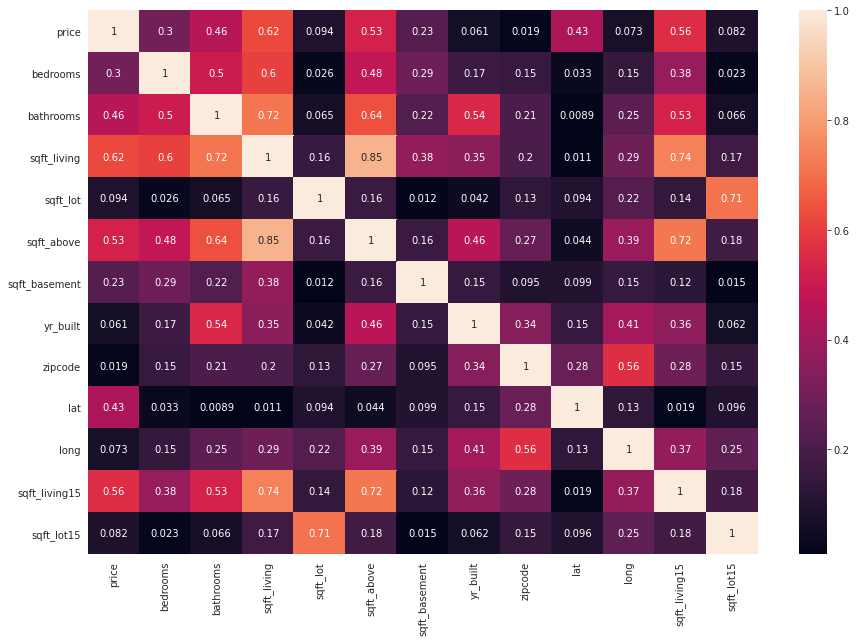

In [24]:
# sns.heatmap(df.corr(),annot=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 10))
    ax = sns.heatmap(abs(df.corr()),annot=True)

Note the corelation between
- sqft_living and sqft_above (because sqft_living = sqft_above + sqft_basement). In fact a lot of the sqft are highly corelated
    - try feature engineering between them, or just pick 1 or 2
- grade to sqft_living15, sqft_above
- bathrooms to grade
- grade and sqft_living has highest impact on target (price)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20379 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   price          20379 non-null  float64 
 1   bedrooms       20379 non-null  int64   
 2   bathrooms      20379 non-null  float64 
 3   sqft_living    20379 non-null  int64   
 4   sqft_lot       20379 non-null  int64   
 5   waterfront     18115 non-null  object  
 6   view           20379 non-null  object  
 7   condition      20379 non-null  object  
 8   grade          20379 non-null  object  
 9   sqft_above     20379 non-null  int64   
 10  sqft_basement  20379 non-null  int64   
 11  yr_built       20379 non-null  int64   
 12  zipcode        20379 non-null  int64   
 13  lat            20379 non-null  float64 
 14  long           20379 non-null  float64 
 15  sqft_living15  20379 non-null  int64   
 16  sqft_lot15     20379 non-null  int64   
 17  bedrooms_bin   20379 non-null  

In [26]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
waterfront       2264
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
bedrooms_bin        0
dtype: int64

In [27]:
df.waterfront.isna().sum() / len(df)

0.11109475440404337

We'll have to keep an eye on the waterfront. Maybe drop the values? ~11% of data. Fill with 'NO'

In [28]:
df.waterfront = df.waterfront.fillna('NO')

In [29]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
bedrooms_bin     0
dtype: int64

## Helper Functions

In [30]:
def OHE_scale_lr(X_train,y_train,
                 X_test,y_test,
                 
                 num_col,
                 cat_col =[]
                ):
    """
    Creates a pipeline to perform a 
    - One-Hot-Encoding (OHE)
    - Standard Scaling
    - Linear Regression

    cat_col = list of categorical column names to process with OHE. default empty list
    num_col = list of numerical column names
    
    Keep transformations out of this function. Function applid post train-test split
    """
    if not (cat_col or num_col):
        print("no columns provided to perform operations")
        return None
    
    #List Comp to get subst of columns
    list_cols= [col for sublist_cols in [num_col,cat_col]for col in sublist_cols]
    print('Categorical columns:',cat_col,'\nNumerical Columns: ',num_col)
    
    #Create subsets of train and test sets
    X_train_subset = X_train[list_cols]
    X_test_subset = X_test[list_cols]
    
    
    if cat_col:
        X_train_subset,X_test_subset = OHEColXFER(cat_col,X_train_subset, X_test_subset)
    
    pipe = make_pipeline(StandardScaler(), LinearRegression())
    pipe.fit(X_train_subset, y_train) 
    
    train_preds= pipe.predict(X_train_subset)
    test_preds = pipe.predict(X_test_subset)

    print("Training Score:",pipe.score(X_train_subset, y_train))
    print("Test Score:",pipe.score(X_test_subset, y_test))
    get_train_test_metrics(y_train,train_preds,y_test,test_preds)
    

    return X_train_enc,X_test_enc

In [31]:
def OHEColXFER(cat_col,X_train_subset, X_test_subset):
    """
    In place column transformation using One Hot Encoding 
    """ 
    
    #Instantiate Encoder
    encoder = OneHotEncoder(handle_unknown='error',
                            drop='first',
                            categories='auto')
    
    #Instantiate Column Transformer
    ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

    #Fit Column Transformer
    ct.fit(X_train_subset)

    #Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
    try:
        X_train_enc = ct.transform(X_train_subset).todense()
    except:
        X_train_enc = ct.transform(X_train_subset)
    
    try:
        X_test_enc = ct.transform(X_test_subset).todense()
    except:
        X_test_enc = ct.transform(X_test_subset)
    
    # Get a nice dataframe
    X_train_enc = pd.DataFrame(X_train_enc, columns=ct.get_feature_names())
    X_test_enc = pd.DataFrame(X_test_enc, columns=ct.get_feature_names())
    

In [32]:
def get_train_test_metrics(y_train,train_preds,
               y_test,test_preds
              ):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    # R2
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    # R2
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

In [33]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

## Train Test split

In [34]:
# Define our X and y
X = df.drop(columns='price')
y = df['price']

In [35]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Models

### Model 00. Dummy Regressor

In [36]:
dummy = DummyRegressor() #mean strategy

In [37]:
dummy.fit(X_train,y_train)

DummyRegressor()

In [38]:
dummy.score(X_train,y_train)

0.0

In [39]:
dummy.score(X_test,y_test)

-8.727889404758216e-06

Dummy Regressor has a 0 R^2 score?

### Model 0. Using highest corr coefficient feature: sqft_living

In [42]:
df.corr().price.sort_values()[-2:]

sqft_living    0.621509
price          1.000000
Name: price, dtype: float64

In [43]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living']
Training Score: 0.38724291100841735
Test Score: 0.383954425521002

Training Metrics:
R2: 0.387
Mean Absolute Error: 131306.631
Mean Squared Error: 26535522450.985
Root Mean Squared Error: 162897.276

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130433.433
Mean Squared Error: 26429196077.413
Root Mean Squared Error: 162570.588


NameError: name 'X_train_enc' is not defined

Any chosen model **should perform better than this**

###  Model 1 : Sqft_living, grade

Note: These should have a high colinearity. Just curious

In [44]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living']


TypeError: cannot unpack non-iterable NoneType object

### Model 2: Sqft_living/Sqft_living15, grade

Feature engineering a ratio of living area to that of the neighborhood. Thinking: biggest house in the neighborhood is a good predicter

In [45]:
X_train['sqft_living/sqft_living15'] = X_train.sqft_living / X_train.sqft_living15
X_test['sqft_living/sqft_living15'] = X_test.sqft_living / X_test.sqft_living15

In [46]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_living15'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_living15']


TypeError: cannot unpack non-iterable NoneType object

yeesh

### Model 3: Sqft_living, Sqft_lot,grade

Trying variations of Sqft_living and Sqft_lot
Thinking: Either individually, an addition or a ratio of the living/lot might be a good predicter

#### Model 3a: Sqft_living, Sqft_lot

In [47]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_lot'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['sqft_living', 'sqft_lot']
Training Score: 0.3872454358288966
Test Score: 0.38399515410064355

Training Metrics:
R2: 0.387
Mean Absolute Error: 131302.720
Mean Squared Error: 26535413113.318
Root Mean Squared Error: 162896.940

Testing Metrics:
R2: 0.384
Mean Absolute Error: 130426.689
Mean Squared Error: 26427448765.750
Root Mean Squared Error: 162565.214


NameError: name 'X_train_enc' is not defined

probably also has high multicolinarity. Also, not much better than Model 0

#### Model 3b: Sqft_living + Sqft_lot, grade

In [48]:
X_train['sqft_living + sqft_lot'] = X_train['sqft_living'] + X_train['sqft_lot']
X_test['sqft_living + sqft_lot'] = X_test['sqft_living'] + X_test['sqft_lot']

In [49]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living + sqft_lot'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living + sqft_lot']


TypeError: cannot unpack non-iterable NoneType object

#### Model 3c: Sqft_living / Sqft_lot, grade

In [50]:
X_train['sqft_living/sqft_lot'] = X_train['sqft_living'] / X_train['sqft_lot']
X_test['sqft_living/sqft_lot'] = X_test['sqft_living'] / X_test['sqft_lot']

In [51]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living/sqft_lot'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['sqft_living/sqft_lot']


TypeError: cannot unpack non-iterable NoneType object

Feature engineering betwen sqft_living and sqft_lot makes no diff

### Model 4: View, Waterfront, Grade

Something different. No square footage. Based on view, waterfront, grade. Will require little more work, since waterfront has a bunch of nulls

In [ ]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = [],
                 cat_col =['view','waterfront','grade']
                )

Better, but meh. Marginally better than Model 0

### Model 5: Bedroom, Bathroom, sqft_living

ok. ignoring square footage probably not a good idea. Using room counts as a predicter

#### Model 5a

In [52]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =[]
                )

Categorical columns: [] 
Numerical Columns:  ['bedrooms', 'bathrooms', 'sqft_living']
Training Score: 0.3954060646579909
Test Score: 0.395010827929423

Training Metrics:
R2: 0.395
Mean Absolute Error: 129877.861
Mean Squared Error: 26182016060.230
Root Mean Squared Error: 161808.578

Testing Metrics:
R2: 0.395
Mean Absolute Error: 128775.430
Mean Squared Error: 25954861321.563
Root Mean Squared Error: 161105.125


NameError: name 'X_train_enc' is not defined

#### Model 5b

In [53]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['bedrooms_bin']
                )

Categorical columns: ['bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']


TypeError: cannot unpack non-iterable NoneType object

Binning bedrooms has a marginal improvement

### Model 6: Bedroom, Bathroom, sqft_living, grade

#### Model 6a

In [ ]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bedrooms','bathrooms'],
                 cat_col =['grade']
                )

In [54]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living'],
                 cat_col =['grade','bedrooms_bin']
                )

Categorical columns: ['grade', 'bedrooms_bin'] 
Numerical Columns:  ['bathrooms', 'sqft_living']


TypeError: cannot unpack non-iterable NoneType object

Getting better. Seems like better off treating bedrooms as cateogrical.

Hmmm... Including sqft_living AND grade increased scores. But their corelation is high. Probably high multicolinearity. Check a few more models

#### Model 6b: Bedroom/Bathroom, sqft_living, grade

Slight feature engineering. Ratio of bedrooms to bathrooms

In [ ]:
X_train['bedrooms/bathrooms'] = X_train['bedrooms']/X_train['bathrooms']
X_test['bedrooms/bathrooms'] = X_test['bedrooms']/X_test['bathrooms']

In [55]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms/bathrooms','sqft_living'],
                 cat_col =['grade']
                )

Categorical columns: ['grade'] 
Numerical Columns:  ['bedrooms/bathrooms', 'sqft_living']


KeyError: "['bedrooms/bathrooms'] not in index"

Not that much better

## Ze Kitchen Sink

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['zipcode'],df['price'])

If considering zip code, I think it should be considered as a categorical

### Model 7: zipcode included

#### Model 7a

In [56]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['zipcode','sqft_living','bathrooms',],
                 cat_col =['condition','bedrooms_bin',]
                )

Categorical columns: ['condition', 'bedrooms_bin'] 
Numerical Columns:  ['zipcode', 'sqft_living', 'bathrooms']


TypeError: cannot unpack non-iterable NoneType object

#### Model 7b

In [57]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','bathrooms',],
                 cat_col =['bedrooms_bin','zipcode','condition']
                )

Categorical columns: ['bedrooms_bin', 'zipcode', 'condition'] 
Numerical Columns:  ['sqft_living', 'bathrooms']


TypeError: cannot unpack non-iterable NoneType object

PROMISING! 

$_{only~thing~so~far}$

#### Model 7c

In [ ]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition']
                )

#### Model 7d

In [58]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living'],
                 cat_col =['zipcode','condition','view','waterfront']
                )

Categorical columns: ['zipcode', 'condition', 'view', 'waterfront'] 
Numerical Columns:  ['sqft_living']


TypeError: cannot unpack non-iterable NoneType object

#### Model 7e

In [ ]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bedrooms','bathrooms','sqft_living'],
                 cat_col =['zipcode','condition','view']
                )

#### Model 7f

In [ ]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['bathrooms','sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin',]
                )

Best one yet

In [59]:
df.yr_built.isna().sum()

0

In [60]:
OHE_scale_lr(X_train,y_train,
                 X_test,y_test,                 
                 num_col = ['sqft_living','sqft_living15'],
                 cat_col =['zipcode','condition','view','bedrooms_bin']
                )

Categorical columns: ['zipcode', 'condition', 'view', 'bedrooms_bin'] 
Numerical Columns:  ['sqft_living', 'sqft_living15']


TypeError: cannot unpack non-iterable NoneType object

## Deepdive in Model 7f

Get all the necessary variables (R^2, Condition No, p-values, coeffiencts, intercept)

### First a sanity check. Manual Run of methods

In [61]:
cols = ['sqft_living','sqft_living15','zipcode','condition','view','bedrooms_bin']
cat_col =['zipcode','condition','view','bedrooms_bin']
X_train_subset = X_train[cols]
X_test_subset = X_test[cols]

In [62]:
cs=[]

X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['zipcode'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['condition'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['view'])
cs = cs + c
X_train_subset,X_test_subset,c = ohe(X_train_subset,X_test_subset,['bedrooms_bin'])
cs = cs + c

cs = cs +['sqft_living','sqft_living15']
X_train_enc = X_train_subset[cs]
X_test_enc = X_test_subset[cs]

In [63]:
X_train_enc

,zipcode_x0_98002,zipcode_x0_98003,zipcode_x0_98004,zipcode_x0_98005,zipcode_x0_98006,zipcode_x0_98007,zipcode_x0_98008,zipcode_x0_98010,zipcode_x0_98011,zipcode_x0_98014,...,view_x0_GOOD,view_x0_NONE,bedrooms_bin_x0_2BR,bedrooms_bin_x0_3BR,bedrooms_bin_x0_4BR,bedrooms_bin_x0_5BR,bedrooms_bin_x0_6BR,bedrooms_bin_x0_7+BR,sqft_living,sqft_living15
4535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3380,2250
14745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1330,1400
19299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1120,1620
20872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1230,1230
9182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1110,1230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4690,2910
12650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1740,1260
5700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1880,2520
909,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1420,1660


In [64]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first',
                        categories='auto')
ct = ColumnTransformer(transformers=[('ohe', encoder, cat_col)],
                           remainder='passthrough')

#Fit Column Transformer
ct.fit(X_train_subset)

#Get your encoded Training and Test sets. Sometimes need to force todens(0) depending upon size of output
try:
    X_train_enc = ct.transform(X_train_subset).todense()    
except:
    X_train_enc = ct.transform(X_train_subset)

try:
    X_test_enc = ct.transform(X_test_subset).todense()
except:
    X_test_enc = ct.transform(X_test_subset)


In [65]:
#Scale
scaler = StandardScaler() #IQR and scaled
scaler.fit(X_train_enc)
X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [66]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression()

In [67]:
train_preds=lr.predict(X_train_scaled)
test_preds=lr.predict(X_test_scaled)

train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

In [68]:
get_train_test_metrics(y_train,train_preds,y_test,test_preds)


Training Metrics:
R2: 0.805
Mean Absolute Error: 66932.149
Mean Squared Error: 8446142367.882
Root Mean Squared Error: 91902.896

Testing Metrics:
R2: 0.806
Mean Absolute Error: 66687.939
Mean Squared Error: 8333691661.519
Root Mean Squared Error: 91289.056


In [69]:
90980.964/df.price.median()

0.20795648914285716

In [70]:
90980.964/df.price.mean()

0.1908585506777202

Roughly 20% error predicting prices when compared to meadian house price

In [71]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train_subset.index, columns=cs)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test_subset.index, columns=cs)

ValueError: Shape of passed values is (14265, 168), indices imply (14265, 85)

In [79]:
X_train_scaled

array([[-0.10027223, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894],
       [-0.10027223, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894],
       [-0.10027223, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894],
       ...,
       [-0.10027223, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894],
       [ 9.97285047, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894],
       [-0.10027223, -0.11984963, -0.09054534, ..., -0.26454111,
        -0.10308731, -0.04887894]])

### OLS Summary

In [80]:
#Just to get summary
model = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     672.2
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:17:04   Log-Likelihood:            -1.8341e+05
No. Observations:               14265   AIC:                         3.670e+05
Df Residuals:                   14179   BIC:                         3.676e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.764e+05    791.974    601.563      0.000    4.75e+05    4.78e+05
x1         -8.278e+14    1.2e+16     -0.069      0.945   -2.44e+16    2.27e+16
x2          1.724e+16   1.46e+16      1.179      0.238   -1.14e+16    4.59e+16
x3         -2.965e+16   1.67e+16     -1.773      0.076   -6.24e+16    3.14e+15
x4          7.996e+15      1e+16      0.797      0.425   -1.17e+16    2.77e+16
x5          8.798e+15   3.58e+16      0.246      0.806   -6.13e+16    7.89e+16
x6         -2.605e+16   1.57e+16     -1.661      0.097   -5.68e+16    4.69e+15
x7          1.333e+16   1.64e+16      0.814      0.416   -1.88e+16    4.54e+16
x8          3.294e+16   3.43e+16      0.960      0.337   -3.43e+16       1e+17
x9         -3.694e+15   1.55e+16     -0.238      0.812   -3.41e+16    2.67e+16
x10         1.901e+16   2.25e+16      0.844      0.399   -2.51e+16    6.31e+16
x11         1.906e+16   1.51e+16      1.266      0.206   -1.05e+16    4.86e+16
x12         1.908e+16   1.28e+16      1.495      0.135   -5.94e+15    4.41e+16
x13          6.71e+15   1.37e+16      0.488      0.625   -2.02e+16    3.36e+16
x14        -5.007e+16    5.3e+16     -0.945      0.345   -1.54e+17    5.38e+16
x15         1.883e+16   2.68e+16      0.701      0.483   -3.38e+16    7.15e+16
x16         8.632e+16   7.31e+16      1.180      0.238    -5.7e+16     2.3e+17
x17        -9.373e+15   2.32e+16     -0.403      0.687   -5.49e+16    3.62e+16
x18        -2.098e+16   1.82e+16     -1.156      0.248   -5.66e+16    1.46e+16
x19         1.201e+16   3.84e+16      0.313      0.754   -6.32e+16    8.72e+16
x20        -1.421e+16   1.67e+16     -0.849      0.396    -4.7e+16    1.86e+16
x21         9.288e+15   1.86e+16      0.499      0.618   -2.72e+16    4.58e+16
x22        -3.467e+16   2.13e+16     -1.630      0.103   -7.64e+16    7.02e+15
x23         1.479e+15   1.62e+16      0.091      0.927   -3.04e+16    3.33e+16
x24         8.991e+15      2e+16      0.450      0.653   -3.01e+16    4.81e+16
x25         3.638e+16   2.34e+16      1.558      0.119    -9.4e+15    8.22e+16
x26         2.503e+16   3.63e+16      0.689      0.491   -4.62e+16    9.62e+16
x27         1.512e+17   1.41e+17      1.073      0.283   -1.25e+17    4.27e+17
x28         1.397e+15   1.76e+16      0.079      0.937   -3.31e+16    3.59e+16
x29         3.332e+15   2.02e+16      0.165      0.869   -3.62e+16    4.29e+16
x30         5.181e+16   4.54e+16      1.140      0.254   -3.72e+16    1.41e+17
x31         1.079e+17   8.16e+16      1.322      0.186   -5.21e+16    2.68e+17
x32        -5.105e+14   4.58e+16     -0.011      0.991   -9.03e+16    8.93e+16
x33         4.692e+16   3.76e+16      1.247      0.212   -2.68e+16    1.21e+17
x34         -7.91e+16   6.99e+16     -1.131      0.258   -2.16e+17     5.8e+16
x35         8.825e+16   4.99e+16      1.769      0.077   -9.55e+15    1.86e+17
x3

In [72]:
#Just to get summary
model = sm.OLS(endog=y_test, exog=sm.add_constant(X_test_scaled)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     291.8
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:16:36   Log-Likelihood:                -78528.
No. Observations:                6114   AIC:                         1.572e+05
Df Residuals:                    6028   BIC:                         1.578e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.763e+05   1319.104    361.097      0.000    4.74e+05    4.79e+05
x1          1.216e+17   9.28e+16      1.310      0.190   -6.04e+16    3.04e+17
x2         -6.469e+16   1.71e+17     -0.378      0.705      -4e+17     2.7e+17
x3          8.898e+16   1.78e+17      0.499      0.618   -2.61e+17    4.39e+17
x4          3.796e+16   5.79e+16      0.656      0.512   -7.55e+16    1.51e+17
x5         -4.931e+16   6.52e+16     -0.756      0.450   -1.77e+17    7.86e+16
x6         -4.063e+16   7.27e+16     -0.559      0.576   -1.83e+17    1.02e+17
x7          4.629e+16    5.9e+16      0.785      0.433   -6.93e+16    1.62e+17
x8         -3.884e+15    5.1e+16     -0.076      0.939   -1.04e+17    9.61e+16
x9          -6.83e+16   5.54e+16     -1.233      0.218   -1.77e+17    4.03e+16
x10        -1.178e+16   2.11e+17     -0.056      0.955   -4.25e+17    4.02e+17
x11        -9.845e+16   1.77e+17     -0.555      0.579   -4.46e+17    2.49e+17
x12         1.706e+16   5.82e+16      0.293      0.769    -9.7e+16    1.31e+17
x13         4.908e+16   1.91e+17      0.257      0.797   -3.25e+17    4.23e+17
x14         1.468e+16   5.56e+16      0.264      0.792   -9.43e+16    1.24e+17
x15         1.337e+17   9.25e+16      1.444      0.149   -4.78e+16    3.15e+17
x16        -1.951e+16   4.94e+16     -0.395      0.693   -1.16e+17    7.74e+16
x17         4.596e+16   9.93e+16      0.463      0.644   -1.49e+17    2.41e+17
x18         6.205e+16   8.01e+16      0.775      0.439    -9.5e+16    2.19e+17
x19         1.249e+17   1.43e+17      0.874      0.382   -1.55e+17    4.05e+17
x20         2.046e+17   1.95e+17      1.049      0.294   -1.78e+17    5.87e+17
x21         2.255e+17   1.51e+17      1.490      0.136   -7.12e+16    5.22e+17
x22         1.379e+17   1.98e+17      0.696      0.487   -2.51e+17    5.27e+17
x23         1.094e+17   1.45e+17      0.756      0.449   -1.74e+17    3.93e+17
x24         9.047e+15   2.23e+16      0.407      0.684   -3.46e+16    5.27e+16
x25         1.312e+17   1.66e+17      0.790      0.429   -1.94e+17    4.57e+17
x26         1.032e+17   1.43e+17      0.719      0.472   -1.78e+17    3.84e+17
x27         9.064e+16    1.1e+17      0.822      0.411   -1.26e+17    3.07e+17
x28        -2.348e+16   8.53e+16     -0.275      0.783   -1.91e+17    1.44e+17
x29        -6.429e+16   7.03e+16     -0.915      0.360   -2.02e+17    7.35e+16
x30         1.844e+17   2.57e+17      0.717      0.474    -3.2e+17    6.89e+17
x31         7.488e+16   1.76e+17      0.426      0.670    -2.7e+17    4.19e+17
x32        -1.335e+17   1.53e+17     -0.872      0.383   -4.34e+17    1.67e+17
x33         1.257e+15   4.98e+16      0.025      0.980   -9.64e+16    9.89e+16
x34         2.936e+17   1.53e+17      1.914      0.056   -7.05e+15    5.94e+17
x35        -5.584e+15   1.79e+17     -0.031      0.975   -3.57e+17    3.46e+17
x3

In [73]:
model.params

const    4.763244e+05
x1       1.216134e+17
x2      -6.468925e+16
x3       8.897531e+16
x4       3.795569e+16
             ...     
x164    -1.787505e+17
x165     2.213261e+16
x166     1.347470e+16
x167     3.443161e+16
x168    -4.238528e+16
Length: 169, dtype: float64

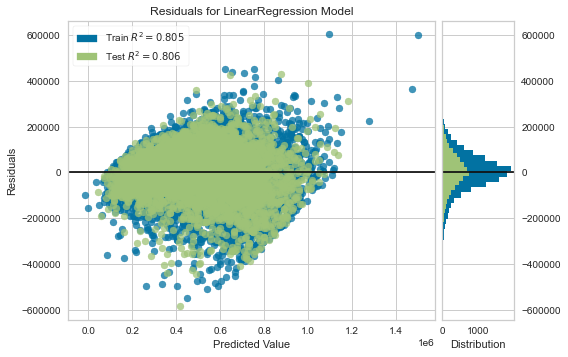

In [74]:
# visualizing our residuals 
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

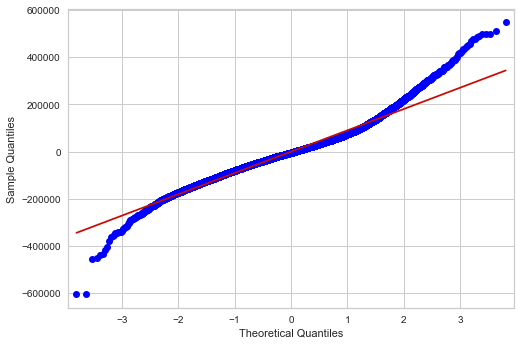

In [75]:
sm.qqplot(train_residuals, line = 'r');

Makes intuitive sense. Intercept around 470k. Houses around King County are expensive: mean 540k, median: 450k

Some zip codes have a much higher impact on prices. pricier neighborhoods

In [76]:
X_train_subset.sqft_living

4535     3380
14745    1330
19299    1120
20872    1230
9182     1110
         ... 
11933    4690
12650    1740
5700     1880
909      1420
16714    1730
Name: sqft_living, Length: 14265, dtype: int64

## LOG (Price)

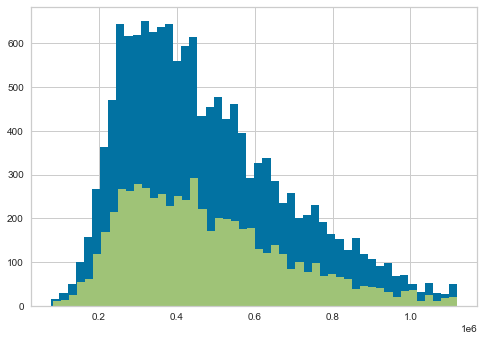

In [77]:
plt.hist(y_train,bins = 50)
plt.hist(y_test,bins = 50);

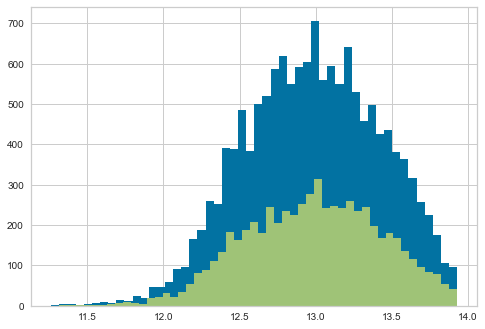

In [78]:
plt.hist(np.log(y_train),bins = 50)
plt.hist(np.log(y_test),bins = 50);

In [ ]:
#USE encoded training and test  sets here!
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

pipe_log = make_pipeline(RobustScaler(), LinearRegression())
pipe_log.fit(X_train_enc, log_y_train) 
print("Training Score:",pipe_log.score(X_train_enc, log_y_train))
print("Test Score:",pipe_log.score(X_test_enc, log_y_test))

In [ ]:
train_preds = pipe_log.predict(X_train_enc)
test_preds = pipe_log.predict(X_test_enc)

train_residuals = log_y_train - train_preds
test_residuals = log_y_test - test_preds

In [ ]:
get_train_test_metrics(log_y_train,train_preds,
                      log_y_test,test_preds)

In [ ]:
np.exp(0.191)

In [ ]:
get_train_test_metrics(np.exp(log_y_train),np.exp(train_preds),
                      np.exp(log_y_test),np.exp(test_preds))

In [ ]:
#Just to get summary
model = sm.OLS(endog=log_y_train, exog=sm.add_constant(X_train_scaled)).fit()
model.summary()

In [ ]:
plt.hist(train_residuals,bins = 50);
plt.hist(test_residuals,bins = 50);

In [ ]:
sm.qqplot(train_residuals, line = 'r');

WORSE!

## Some weird plots

In [ ]:
df_pairplotting1 = df.filter(['bedrooms','bathrooms','floors','view','condition','price'])
df_pairplotting2 = df.filter(['bedrooms','sqft_living', 'sqft_lot','sqft_above','sqft_living15', 'sqft_lot15','price'])

In [ ]:
sns.pairplot(df_pairplotting1)

In [ ]:
sns.pairplot(df_pairplotting2)